# Scikit Image Experimentation

## General notes
- It may be useful to use the [skeletonize](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skeletonize) function to reduce web pictures down to 1px lines for splining.
- We should possibly end up fitting B-splines to the web?
- Diffs should be possible using [compare_images](https://scikit-image.org/docs/stable/api/skimage.util.html#compare-images)

In [1]:
import skimage as img
import cv2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
# %matplotlib notebook
from skimage import io
from skimage import filters
plt.rcParams["figure.figsize"] = (15,10)
import os

## Hidden setup stuff

In [3]:
import IPython.core.display

def _html_repr_helper(contents, index, is_horz):
    dims_left = contents.ndim - len(index)
    if dims_left == 0:
        s = contents[index]
    else:
        s = '<span class="numpy-array-comma">,</span>'.join(
            _html_repr_helper(contents, index + (i,), is_horz) for i in range(contents.shape[len(index)])
        )
        s = ('<span class="numpy-array-bracket numpy-array-bracket-open">[</span>'
            '{}'
            '<span class="numpy-array-bracket numpy-array-bracket-close">]</span>'.format(s))
        
    # apply some classes for styling
    classes = []
    classes.append('numpy-array-slice')
    classes.append('numpy-array-ndim-{}'.format(len(index)))
    classes.append('numpy-array-ndim-m{}'.format(dims_left))
    if is_horz(contents, len(index)):
        classes.append('numpy-array-horizontal')
    else:
        classes.append('numpy-array-vertical')
    
    hover_text = '[{}]'.format(','.join('{}'.format(i) for i in (index + (':',) * dims_left)))

    return "<span class='{}' title='{}'>{}</span>".format(
        ' '.join(classes), hover_text, s,
    )

basic_css = """
    .numpy-array {
        display: inline-block;
    }
    .numpy-array .numpy-array-slice {
        border: 1px solid #cfcfcf;
        border-radius: 4px;
        margin: 1px;
        padding: 1px;
        display: flex;
        flex: 1;
        text-align: right;
        position: relative;
    }
    .numpy-array .numpy-array-slice:hover {
        border: 1px solid #66BB6A;
    }
    .numpy-array .numpy-array-slice.numpy-array-vertical {
        flex-direction: column;
    }
    .numpy-array .numpy-array-slice.numpy-array-horizontal {
        flex-direction: row;
    }
    .numpy-array .numpy-array-ndim-m0 {
        padding: 0 0.5ex;
    }
    
    /* Hide the comma and square bracket characters which exist to help with copy paste */
    .numpy-array .numpy-array-bracket {
        font-size: 0;
        position: absolute;
    }
    .numpy-array span .numpy-array-comma {
        font-size: 0;
        height: 0;
    }
"""

show_brackets_css = """
    .numpy-array.show-brackets .numpy-array-slice {
        border-radius: 0;
    }
    .numpy-array.show-brackets .numpy-array-bracket {
        border: 1px solid black; 
        border-radius: 0;  /* looks better without... */
    }
    .numpy-array.show-brackets .numpy-array-horizontal > .numpy-array-bracket-open {
        top: -1px;
        bottom: -1px;
        left: -1px;
        width: 10px;
        border-right: none;
        border-top-right-radius: 0;
        border-bottom-right-radius: 0;
    }
    .numpy-array.show-brackets .numpy-array-horizontal > .numpy-array-bracket-close {
        top: -1px;
        bottom: -1px;
        right: -1px;
        width: 10px;
        border-left: none;
        border-top-left-radius: 0;
        border-bottom-left-radius: 0;
    }
    .numpy-array.show-brackets .numpy-array-vertical > .numpy-array-bracket-open {
        top: -1px;
        right: -1px;
        left: -1px;
        height: 10px;
        border-bottom: none;
        border-bottom-right-radius: 0;
        border-bottom-left-radius: 0;
    }
    .numpy-array.show-brackets .numpy-array-vertical > .numpy-array-bracket-close {
        left: -1px;
        bottom: -1px;
        right: -1px;
        height: 10px;
        border-top: none;
        border-top-right-radius: 0;
        border-top-left-radius: 0;
    }
"""

def make_pretty(self, show_brackets=False, is_horz=lambda arr, ax: ax == arr.ndim - 1):

    classes = ['numpy-array']
    css = basic_css
    if show_brackets:
        classes += ['show-brackets']
        css += show_brackets_css
    return IPython.core.display.HTML(
        """<style>{}</style><div class='{}'>{}</div>""".format(
            css,
            ' '.join(classes),
            _html_repr_helper(self, (), is_horz))
    )

In [4]:
generate_pres_figs = False
pres_fig_size = (16, 8)

In [5]:
# outdir = "demo_full"
outdir = "demo_stick"

In [59]:
# demo_full = io.imread("../data/test/demo_web_full.jpg")
demo_full = io.imread("../data/test/demo_stickweb_full.jpg")
demo_med = io.imread("../data/test/demo_web_med.jpg")
demo_low = io.imread("../data/test/demo_web_low.jpg")
demo_full = io.imread("../data/test/new_method_1.JPG")
# demo_full = demo_low

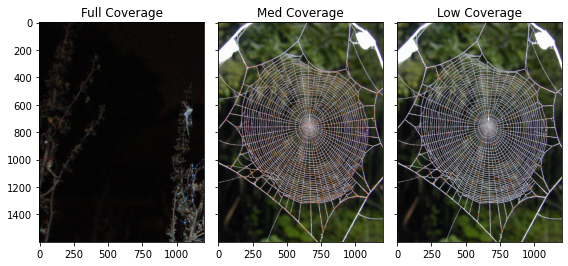

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(demo_full)
ax[1].imshow(demo_med)
ax[2].imshow(demo_low)

ax[0].set_title('Full Coverage')
ax[1].set_title('Med Coverage')
ax[2].set_title('Low Coverage')

fig.tight_layout()
plt.show()

In [61]:
# Convert to lab colour space to allow colour distances to be calculated
lab_demo_full = img.color.rgb2lab(demo_full)

## Find image averages using k-means clustering
From [StackOverflow](https://stackoverflow.com/questions/43111029/how-to-find-the-average-colour-of-an-image-in-python-with-opencv)

First let's find a traditional average of all pixels

In [62]:
average = demo_full.mean(axis=0).mean(axis=0)
average

array([32.25777029, 29.13037046, 37.04818104])

Next let's perform a kmeans clustering to work out a palette of $n$ colours where here $n = 5$.

In [63]:
pixels = np.float32(demo_full.reshape(-1, 3))

n_colors = 5
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
flags = cv2.KMEANS_RANDOM_CENTERS

_, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
_, counts = np.unique(labels, return_counts=True)

Now let's wrap this in a function for easy use later.

In [64]:
def find_image_palette(image, clusters=5, max_iter=200, epsilon=.1, attempts=10):
    pixels = np.float32(image.reshape(-1, 3))
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, max_iter, epsilon)
    flags = cv2.KMEANS_RANDOM_CENTERS

    _, labels, palette = cv2.kmeans(pixels, clusters, None, criteria, attempts, flags)
    _, counts = np.unique(labels, return_counts=True)
    return palette, labels, counts

In [65]:
palette, labels, counts = find_image_palette(demo_full)
palette

array([[203.41048 , 224.88701 , 238.80751 ],
       [114.41671 , 136.54332 , 176.51312 ],
       [ 35.84444 ,  26.022038,  38.362522],
       [ 71.294   ,  69.943306,  92.418976],
       [ 12.111998,   8.425063,  10.409021]], dtype=float32)

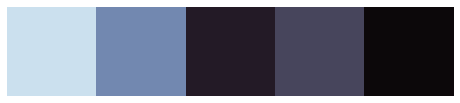

In [66]:
if generate_pres_figs:
    fig,ax = plt.subplots(1, figsize=(pres_fig_size))
else:
    fig,ax = plt.subplots(1, figsize=(8,4))

ax.imshow(np.array([palette], dtype=np.uint8))
ax.axis('off')
plt.show()
if generate_pres_figs:
    plt.savefig(os.path.join("../results", outdir , "palette.png"), bbox_inches='tight', pad_inches = 0)
# io.imshow(np.array([palette], dtype=np.uint8))  # Print it just for fun

The dominant colour is defined here as the cluster-result colour most frequently most similar to pixels in the image.

In [67]:
dominant = palette[np.argmax(counts)]

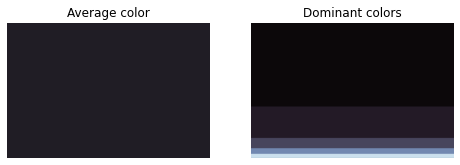

In [68]:
avg_patch = np.ones(shape=demo_full.shape, dtype=np.uint8)*np.uint8(average)  # Using uint8 as we are working in sRGB (so each element can be 0-255)

indices = np.argsort(counts)[::-1]   
freqs = np.cumsum(np.hstack([[0], counts[indices]/counts.sum()]))
rows = np.int_(demo_full.shape[0]*freqs)

dom_patch = np.zeros(shape=demo_full.shape, dtype=np.uint8)
for i in range(len(rows) - 1):
    dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])

if generate_pres_figs:
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=pres_fig_size)
else:
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8,4))
ax0.imshow(avg_patch)
ax0.set_title('Average color')
ax0.axis('off')
ax1.imshow(dom_patch)
ax1.set_title('Dominant colors')
ax1.axis('off')
plt.show()
if generate_pres_figs:
    plt.savefig(os.path.join("../results", outdir , "dominant.png"), bbox_inches='tight', pad_inches = 0.2)

It looks like we can use the euclidean distance in LAB space (found according to CIE76) to correctly identify the most contrasting colour. Let us find the distance between each element of the palette pairwise.

In [69]:
lab_palette = img.color.rgb2lab(np.array([palette]))
palette_colour_difference = np.asmatrix([[img.color.deltaE_cie76(x, y) for x in lab_palette[0]] for y in lab_palette[0]])

# make_pretty(palette_colour_difference.astype(np.int_))
palette_colour_difference.astype(np.int_)

matrix([[   0, 3030, 6781, 5047, 7744],
        [3030,    0, 4264, 2436, 5345],
        [6781, 4264,    0, 1832, 1204],
        [5047, 2436, 1832,    0, 2946],
        [7744, 5345, 1204, 2946,    0]])

Now let's take the mean of each row to get an overall estimate of how "individual" each colour is, and then get the index of the most "individual" colour. 

In [70]:
palette_colour_difference_mean = np.asarray(np.mean(palette_colour_difference, axis=1).flatten())[0]
palette_colour_difference_mean

array([4520.78755675, 3015.28566625, 2816.51198626, 2452.52265725,
       3448.19277954])

In [71]:
contrasting_col_estimate_idx = np.where(palette_colour_difference_mean == np.amax(palette_colour_difference_mean))[0][0]
contrasting_col_estimate_idx = 3    # FW: 180722 - Quick shim to parse own image
contrasting_col_estimate_idx

3

A nice little way to convert the most contrasting colour as hex:

In [72]:
"#{0:02X}{1:02X}{2:02X}".format(*palette[contrasting_col_estimate_idx].astype(np.uint8))

'#47455C'

In [73]:
for i in range(len(palette)):
    print("#{0:02X}{1:02X}{2:02X}".format(*palette[i].astype(np.uint8)))

#CBE0EE
#7288B0
#231A26
#47455C
#0C080A


[71.294    69.943306 92.418976]


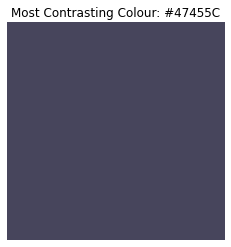

In [74]:
print(palette[contrasting_col_estimate_idx])
if generate_pres_figs:
    fig, ax = plt.subplots(1, figsize=pres_fig_size)
else:
    fig, ax = plt.subplots(1, figsize=(8,4))
# fig,ax = plt.subplots(1, figsize=(8,4))
ax.imshow(np.array([np.array([palette[contrasting_col_estimate_idx]], dtype=np.uint8)]))
ax.axis('off')
ax.set_title("Most Contrasting Colour: #{0:02X}{1:02X}{2:02X}".format(*palette[contrasting_col_estimate_idx].astype(np.uint8)))
plt.show()
# print(np.array([palette], dtype=np.uint8))
if generate_pres_figs:
    plt.savefig(os.path.join("../results", outdir , "contrasting.png"), bbox_inches='tight', pad_inches = 0.2)

And now as a generic function

In [75]:
def estimate_contrasting_colour(palette, return_idx=False):
    lab_palette = img.color.rgb2lab(np.array([palette]))
    delta = np.asmatrix([[img.color.deltaE_cie76(x, y) for x in lab_palette[0]] for y in lab_palette[0]])
    delta_mean = np.asarray(np.mean(delta, axis=1).flatten())[0]
    idx = np.where(delta_mean == np.amax(delta_mean))[0][0]
    if return_idx:
        return idx
    return palette[idx]

def hex2rgb_single(colour):
    colour_raw = colour.lstrip("#")
    if len(colour_raw) == 6:
        colour_raw = np.asarray([int(colour_raw[i:i+2], 16) for i in range(0, len(colour_raw), 2)], dtype=np.float32)
    elif len(colour_raw) == 3:
        colour_raw = np.asarray([int(colour_raw[i]*2, 16) for i in range(0, len(colour_raw))], dtype=np.float32)
    else:
        raise ValueError('colour arg must be a valid hex RGB code. Provided "{}"'.format(colour))
    return colour_raw
    

def closest_contrasting_colour(palette, idcolour, hexcolour=False, showwarnings=True, return_idx=False):
    if hexcolour:
        idcolour = hex2rgb_single(idcolour)
    lab_palette = img.color.rgb2lab(np.array([palette]))
    try:
        lab_idcolour = img.color.rgb2lab(np.array([np.array([idcolour])]))
    except ValueError:
        if showwarnings:
            print("Invalid idcolour: {}\nAttempting with conversion from hexcode (did you forget to provide hexcolour=True?)".format(idcolour))
        idcolour = hex2rgb_single(idcolour)
        lab_idcolour = img.color.rgb2lab(np.array([np.array([idcolour])]))
    delta_mean = np.asarray([img.color.deltaE_cie76(x, lab_idcolour) for x in lab_palette[0]])
    idx = np.where(delta_mean == np.amin(delta_mean))[0][0]
    if return_idx:
        return idx
    return palette[idx]

In [76]:
print(estimate_contrasting_colour(palette))
print(closest_contrasting_colour(palette, np.array([253.70218 , 131.76878 ,   8.609169], dtype=np.float32)))
print(closest_contrasting_colour(palette, "#ff8300", hexcolour=True))  #real colour was #ff8300

[203.41048 224.88701 238.80751]
[203.41048 224.88701 238.80751]
[203.41048 224.88701 238.80751]


[[1.  1.  1.  ... 1.  1.  1. ]
 [1.  1.  1.  ... 1.  1.  1. ]
 [1.  1.  1.  ... 1.  1.  1. ]
 ...
 [0.5 0.5 0.5 ... 1.  1.  0.5]
 [0.5 0.5 1.  ... 1.  0.5 0.5]
 [1.  0.5 1.  ... 1.  1.  0.5]]


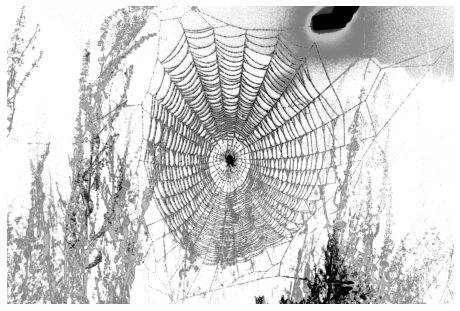

In [77]:
labels_norm = np.asarray((labels / (len(np.unique(labels))-1)).reshape(demo_full.shape[0:2]), dtype=np.float32)
print(labels_norm)
if generate_pres_figs:
    fig, ax = plt.subplots(1, figsize=pres_fig_size)
else:
    fig, ax = plt.subplots(1, figsize=(8,8))
ax.imshow(labels_norm, cmap=plt.cm.gray) # Grayscale version
ax.axis('off')
plt.show()
if generate_pres_figs:
    plt.savefig(os.path.join("../results", outdir , "labels.png"), bbox_inches='tight', pad_inches = 0.2)

<ipython-input-78-38a81827fc6f>:1: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  posterised_image = np.asarray(img.color.label2rgb(labels, colors=palette), dtype=np.uint8).reshape(demo_full.shape)


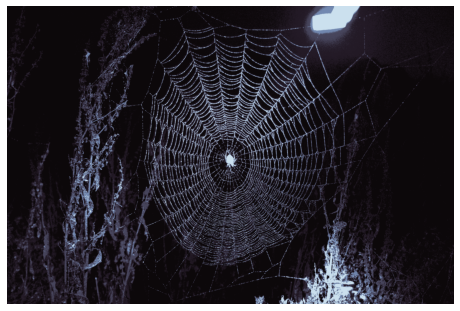

In [78]:
posterised_image = np.asarray(img.color.label2rgb(labels, colors=palette), dtype=np.uint8).reshape(demo_full.shape)

if generate_pres_figs:
    fig, ax = plt.subplots(1, figsize=pres_fig_size)
else:
    fig, ax = plt.subplots(1, figsize=(8,8))

ax.imshow(posterised_image) # Grayscale version
ax.axis('off')
plt.show()
if generate_pres_figs:
    plt.savefig(os.path.join("../results", outdir , "posterised.png"), bbox_inches='tight', pad_inches = 0.2)

In [79]:
dusting = np.where(labels == contrasting_col_estimate_idx, 1, 0).reshape(demo_full.shape[0:2])

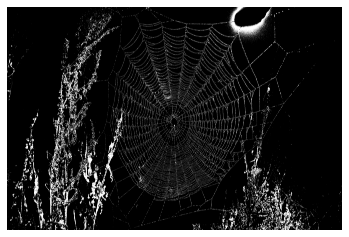

In [80]:
if generate_pres_figs:
    fig, ax = plt.subplots(1, figsize=pres_fig_size)
else:
    fig, ax = plt.subplots(1, figsize=(6,8))
# ax.imshow(dusting)
ax.imshow(dusting, cmap=plt.cm.gray) # Grayscale version
ax.axis('off')
plt.show()
if generate_pres_figs:
    plt.savefig(os.path.join("../results", outdir , "isolated.png"), bbox_inches='tight', pad_inches = 0.2)
# plt.savefig("../results/demo_full_border.png", bbox_inches='tight')  # Save with nice little white border

Could use object classification (maybe reduce res then expand and detect places which look like they've lost the most detail)

## Edge Detection

In [81]:
img.color.rgb2gray(demo_full)

array([[0.02714549, 0.01145922, 0.00753765, ..., 0.05295255, 0.05295255,
        0.07648196],
       [0.01538078, 0.01538078, 0.01538078, ..., 0.07481529, 0.07648196,
        0.06471725],
       [0.00556549, 0.01340863, 0.02517333, ..., 0.06361608, 0.05520745,
        0.03952118],
       ...,
       [0.10380431, 0.09988275, 0.0802749 , ..., 0.06259725, 0.06149608,
        0.09484078],
       [0.08755255, 0.08363098, 0.06066706, ..., 0.07858902, 0.08644706,
        0.09542902],
       [0.07186627, 0.08363098, 0.05674549, ..., 0.06655647, 0.07189961,
        0.08731804]])

First let's take a few different edge filters (specifically Laplace, Scharr & Meijering) and appy them to a greyscale version of the photo.

[[0.01096112 0.01133032 0.00387534 ... 0.01651423 0.01691465 0.0125    ]
 [0.01218423 0.00033858 0.0071171  ... 0.01596563 0.00517601 0.0213451 ]
 [0.00351364 0.00954844 0.00399026 ... 0.01539951 0.03049932 0.02945017]
 ...
 [0.00995291 0.0219651  0.03629128 ... 0.02410784 0.02997467 0.02268769]
 [0.02051559 0.02237219 0.03493108 ... 0.01776058 0.01504641 0.01084164]
 [0.01096112 0.01252457 0.03471977 ... 0.01253806 0.01683248 0.01201647]]


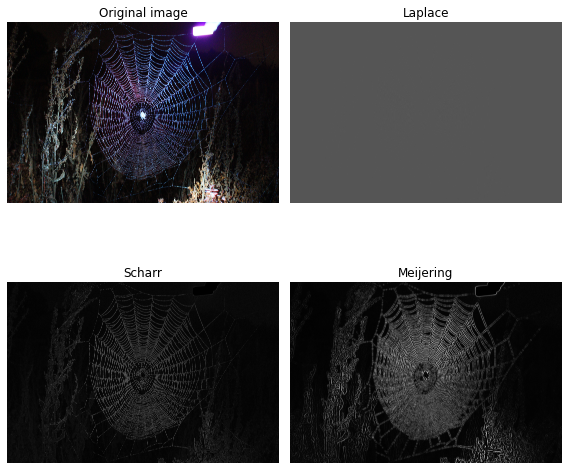

In [82]:
demo_full_lp = filters.laplace(img.color.rgb2gray(demo_full))
demo_full_scharr = filters.scharr(img.color.rgb2gray(demo_full))
print(demo_full_scharr)
demo_full_meijering = filters.meijering(img.color.rgb2gray(demo_full))
# demo_full_lp = filters.laplace(demo_full)
# demo_full_scharr = filters.scharr(demo_full)
# demo_full_meijering = filters.meijering(demo_full)

fig, axes = plt.subplots(nrows=2, ncols=2, 
                         figsize=(8, 8), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(demo_full, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(demo_full_lp, cmap=plt.cm.gray)
ax[1].set_title('Laplace')

ax[2].imshow(demo_full_scharr, cmap=plt.cm.gray)
ax[2].set_title('Scharr')

ax[3].imshow(demo_full_meijering, cmap=plt.cm.gray)
ax[3].set_title('Meijering')

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()
if generate_pres_figs:
    plt.savefig(os.path.join("../results", outdir , "edges.png"), bbox_inches='tight', pad_inches = 0.2)

## Processing convolution
Technically this is not actually convolution, but just weighted averaging of the two images.

**THIS TERMINOLOGY SHOULD BE CORRECTED WHEN MOVING ON FROM THIS NOTEBOOK**

In [83]:
def convolve_processed_images(dusting, edgemap, a=0.5, b=0.5, maskthreshold=0.25):
    if a + b > 1:
        raise ValueError("weightings a and b must not add up to >1!")
    
    # Normalise inputs
    dusting = img.exposure.rescale_intensity(dusting, out_range=(0., 1.))
    edgemap = img.exposure.rescale_intensity(edgemap, out_range=(0., 1.))
    convolved = dusting * a + edgemap * b
    
    invmask = convolved < maskthreshold
    convolved[invmask] = 0
    
    return convolved

In [118]:
convolved = convolve_processed_images(dusting, demo_full_scharr)
convolved = convolve_processed_images(dusting, demo_full_scharr, 0.25, 0.75)

# THIS AFFECTS CONVOLVED BY NOT TAKING A DEEP COPY!!!
mask = convolved > 0.25
invmask = convolved < 0.25

convolved_masked = convolved
convolved_masked[invmask] = 0

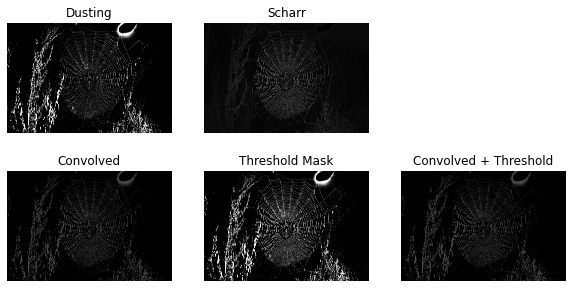

In [119]:
if generate_pres_figs:
    fig, axes = plt.subplots(2, 3, figsize=pres_fig_size)
else:
    fig, axes = plt.subplots(2, 3, figsize=(10, 5), sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(dusting, cmap=plt.cm.gray)
ax[1].imshow(demo_full_scharr, cmap=plt.cm.gray)
ax[3].imshow(convolved, cmap=plt.cm.gray)
ax[4].imshow(mask, cmap=plt.cm.gray)
ax[5].imshow(convolved_masked, cmap=plt.cm.gray)

ax[0].set_title('Dusting')
ax[1].set_title('Scharr')
ax[3].set_title('Convolved')
ax[4].set_title('Threshold Mask')
ax[5].set_title('Convolved + Threshold')

for a in ax:
    a.axis('off')

# fig.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
plt.show()
if generate_pres_figs:
    plt.savefig(os.path.join("../results", outdir , "convolution.png"), bbox_inches='tight', pad_inches = 0.2)

## Skeletonise tests

In [120]:
# fig, axes = plt.subplots(2, 3, figsize=(8, 8), sharex=True, sharey=True)
# ax = axes.ravel()

# ax[0].imshow(img.morphology.skeletonize(dusting), cmap=plt.cm.gray)
# ax[1].imshow(img.morphology.thin(demo_full_scharr), cmap=plt.cm.gray)
# ax[3].imshow(img.morphology.thin(convolved), cmap=plt.cm.gray)
# ax[4].imshow(img.morphology.skeletonize(mask), cmap=plt.cm.gray)
# ax[5].imshow(img.morphology.thin(convolved_masked), cmap=plt.cm.gray)

# ax[0].set_title('Dusting')
# ax[1].set_title('Scharr')
# ax[3].set_title('Convolved')
# ax[4].set_title('Threshold Mask')
# ax[5].set_title('Convolved + Threshold')

# for a in ax:
#     a.axis('off')

# fig.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
# plt.show()

## Harris Corner Detect

The aim here is to detect all corners in the filtered web image using a variety of methods.

In [121]:
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.feature import corner_shi_tomasi, corner_fast, corner_kitchen_rosenfeld
from skimage.exposure import rescale_intensity
coords = corner_peaks(corner_harris(convolved), min_distance=15, threshold_rel=0.2) # cyan
coords_subpix = corner_subpix(convolved, coords, window_size=10) # red
coords_shi_tomasi = corner_peaks(corner_shi_tomasi(convolved), min_distance=15, threshold_rel=0.2) # cyan
coords_fast = corner_peaks(corner_fast(convolved), min_distance=15, threshold_rel=0.2) # cyan
coords_kr = corner_peaks(corner_kitchen_rosenfeld(convolved), min_distance=15, threshold_rel=0.2) # cyan

# flip coords to correctly handle np indexing to image indexing conversion
coords_y, coords_x = zip(*coords)
coords = np.asarray([list(a) for a in zip(coords_x, coords_y)])


-1.0


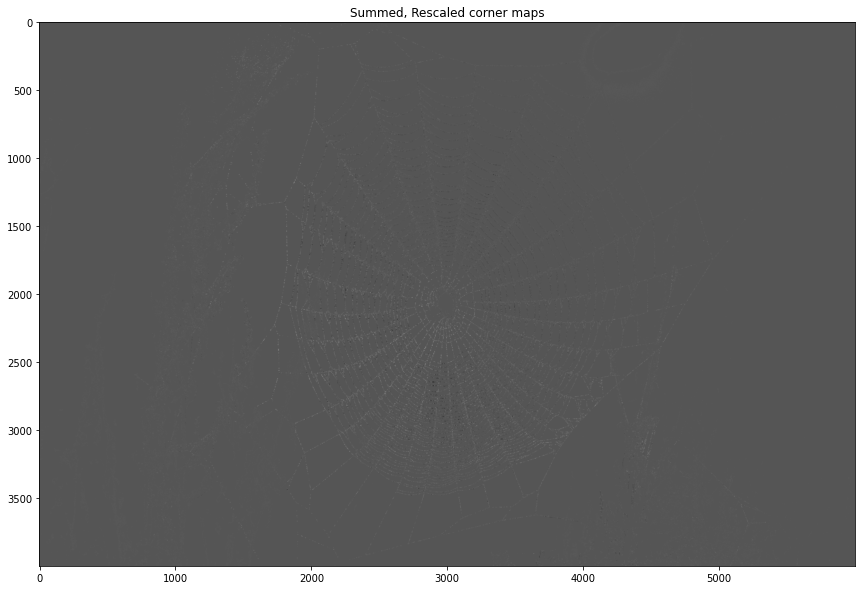

In [122]:
response_img = corner_fast(convolved) + corner_kitchen_rosenfeld(convolved) + corner_shi_tomasi(convolved) + corner_harris(convolved)
response_img = rescale_intensity(response_img)
print(response_img.min())
coords_summed = corner_peaks(response_img, min_distance=20, threshold_rel=0.2)

coords_summed_y, coords_summed_x = zip(*coords_summed)
coords_summed = np.asarray([list(a) for a in zip(coords_summed_x, coords_summed_y)])

fig, ax = plt.subplots()
ax.imshow(corner_harris(convolved), cmap=plt.cm.gray)
ax.set_title('Summed, Rescaled corner maps')
plt.show()

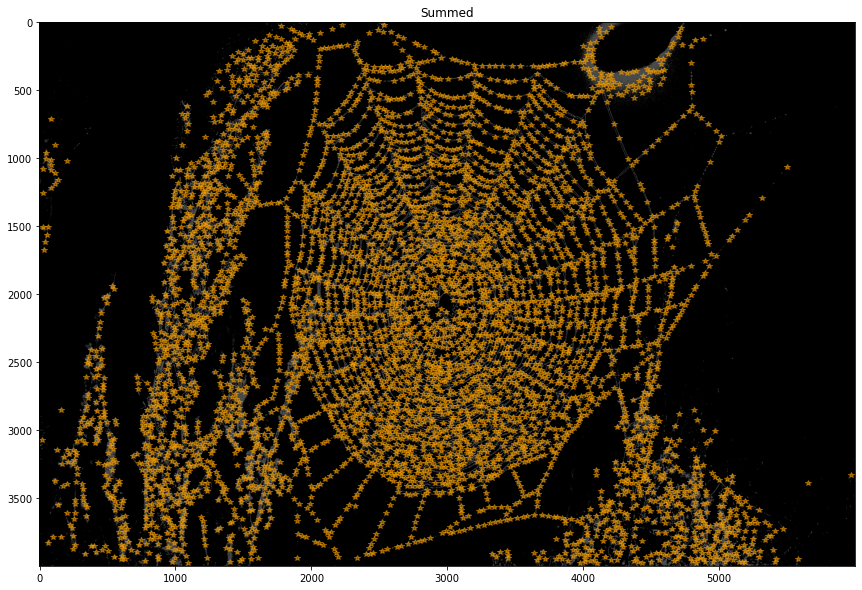

5167


In [123]:
fig, ax = plt.subplots()
ax.imshow(convolved, cmap=plt.cm.gray)
ax.plot(coords_summed[:, 0], coords_summed[:, 1], color='orange', marker='*',
        linestyle='None', markersize=6, alpha=0.5)
ax.set_title('Summed')
plt.show()
print(len(coords_summed))

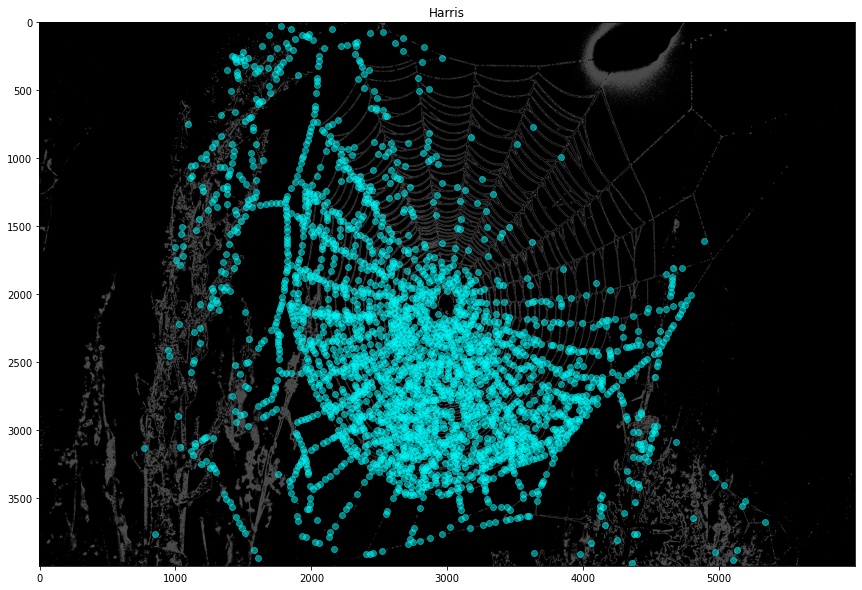

In [124]:
fig, ax = plt.subplots()
ax.imshow(convolved, cmap=plt.cm.gray)
ax.plot(coords[:, 0], coords[:, 1], color='cyan', marker='o',
        linestyle='None', markersize=6, alpha=0.5)
ax.set_title('Harris')
# ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
# ax.axis((0, 310, 200, 0))
plt.show()

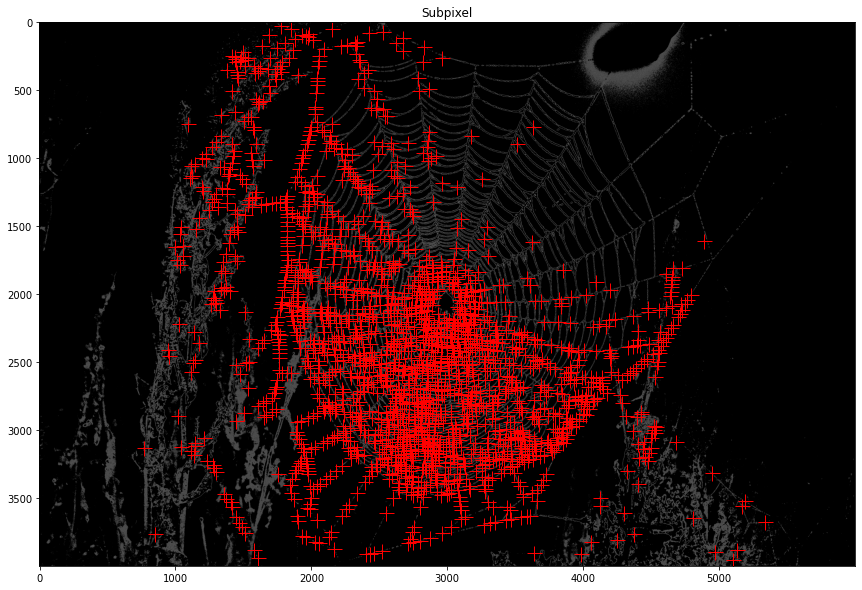

In [125]:
fig, ax = plt.subplots()
ax.imshow(convolved, cmap=plt.cm.gray)
ax.set_title('Subpixel')
# ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
#         linestyle='None', markersize=6, alpha=0.5)
ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
# ax.axis((0, 310, 200, 0))
plt.show()

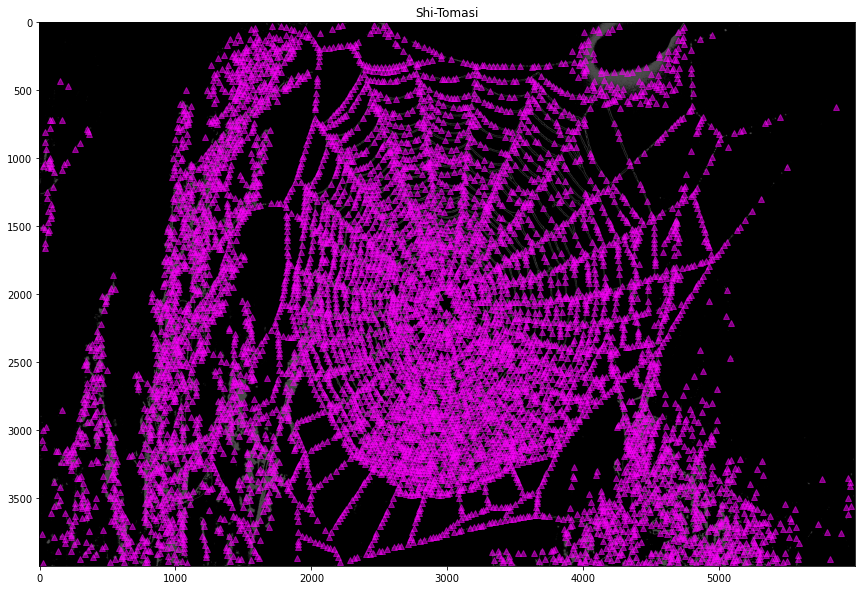

In [126]:
fig, ax = plt.subplots()
ax.imshow(convolved, cmap=plt.cm.gray)
ax.plot(coords_shi_tomasi[:, 1], coords_shi_tomasi[:, 0], color='magenta', marker='^',
        linestyle='None', markersize=6, alpha=0.5)
ax.set_title('Shi-Tomasi')
plt.show()

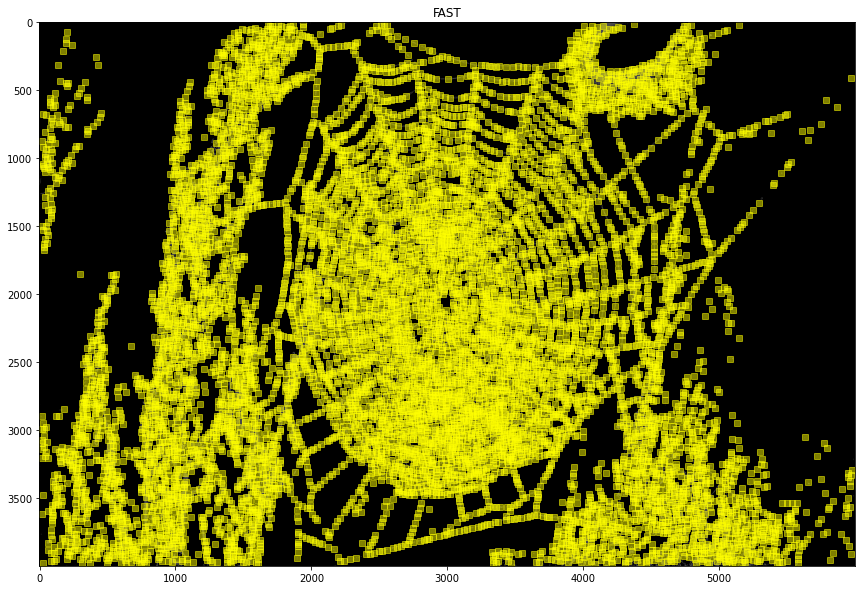

In [127]:
fig, ax = plt.subplots()
ax.imshow(convolved, cmap=plt.cm.gray)
ax.plot(coords_fast[:, 1], coords_fast[:, 0], color='yellow', marker='s',
        linestyle='None', markersize=6, alpha=0.5)
ax.set_title('FAST')
plt.show()

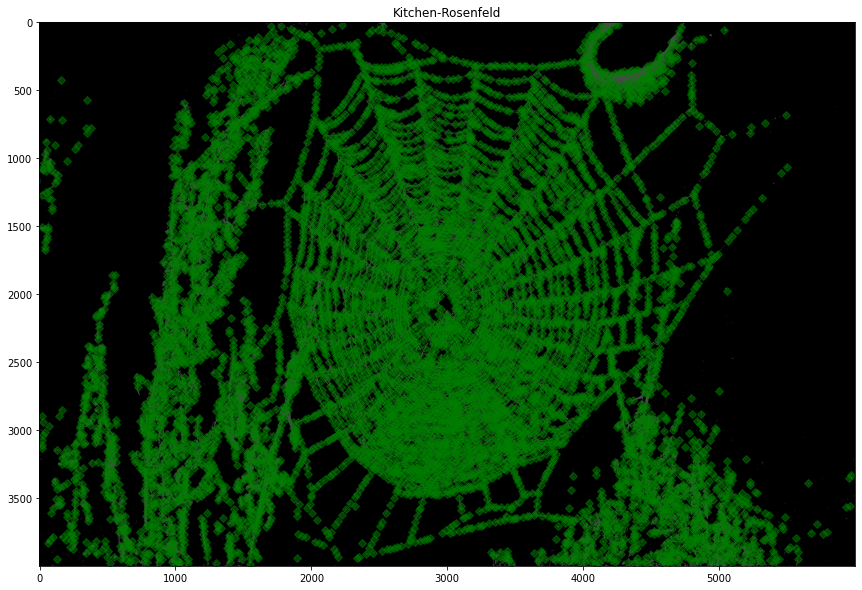

In [128]:
fig, ax = plt.subplots()
ax.imshow(convolved, cmap=plt.cm.gray)
ax.plot(coords_kr[:, 1], coords_kr[:, 0], color='green', marker='D',
        linestyle='None', markersize=6, alpha=0.5)
ax.set_title('Kitchen-Rosenfeld')
plt.show()

In [129]:
coords_summed = coords_kr
coords_summed_y, coords_summed_x = zip(*coords_summed)
coords_summed = np.asarray([list(a) for a in zip(coords_summed_x, coords_summed_y)])

## Joining corners

Next up is to join the identified corners. To do this we need to first find the nearest neghbours within a certain radius. Then we can take transects of the image along these lines [like so](https://stackoverflow.com/questions/7878398/how-to-extract-an-arbitrary-line-of-values-from-a-numpy-array), and look at the number of peaks (or consistency of the resultant plot) to calculate approximately if this is a line that goes through space or one that goes over webs. This at least allows us to cut the majority of lines down and then we can look to find another method to refine this further

20654


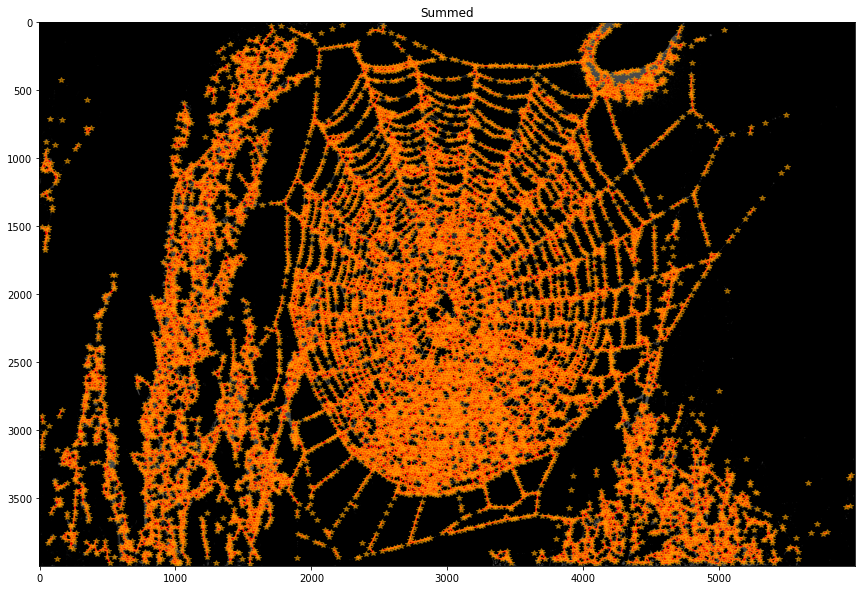

In [130]:
from scipy.spatial import cKDTree
from matplotlib.collections import LineCollection
# Create nearest neighbour tree
corner_tree = cKDTree(coords_summed)

# Find any pairs within 50px of each other
pairs = corner_tree.query_pairs(r=50) # ~10% of the largest dimension?
print(len(pairs))

# For some reason we need to flip the coords that come out of here.
# This is because the corner detection gives np matrix indices. These are in the format y,x.
lines = [[coords_summed[i], coords_summed[j]] for (i, j) in pairs]
linecollection = LineCollection(lines, color="red")

fig, ax = plt.subplots()
ax.imshow(convolved, cmap=plt.cm.gray)
ax.plot(coords_summed[:, 0], coords_summed[:, 1], color='orange', marker='*',
        linestyle='None', markersize=6, alpha=0.5)
ax.set_title('Summed')
ax.add_collection(linecollection)
plt.show()


**NOTE 22/02/22**: Should probably make this return the best `zi` rather than the proportion. This means that the thresholding and foltering can be split out to a seperate function to be played with seperately rather than doing the `filter_crossing_line` repeatedly. This will require a rework to make sure `filter_crossing_line` returns the `zi` that correctly associates with the highest sum pixel value.

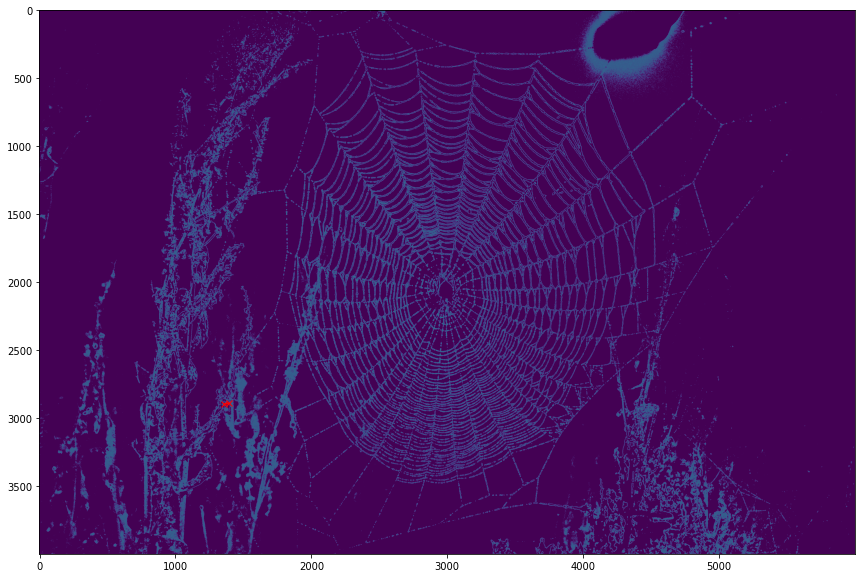

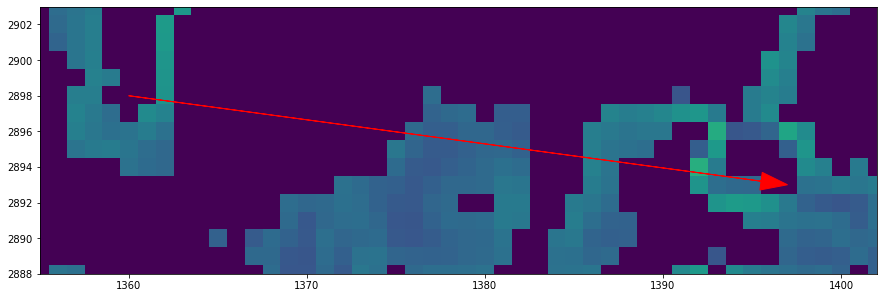

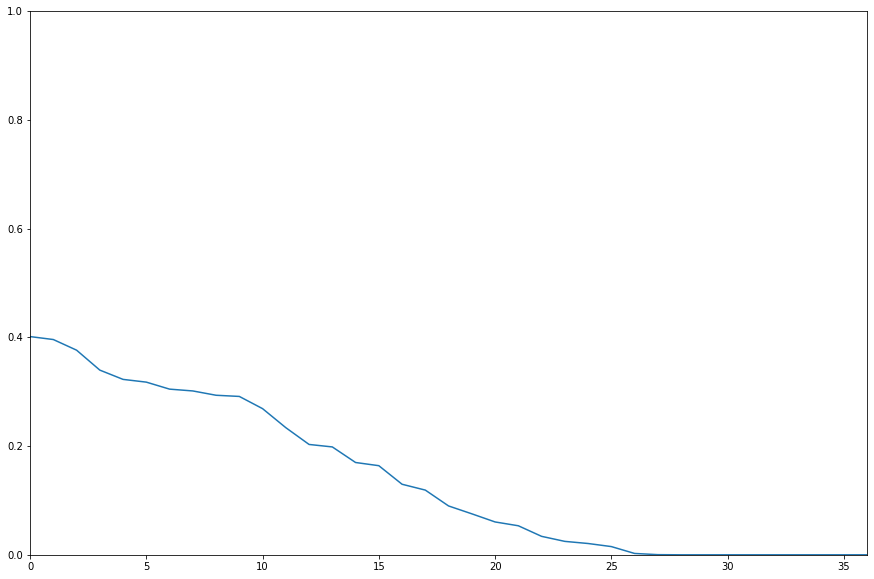

0.0

In [131]:
from scipy.ndimage import map_coordinates
from itertools import chain

def filter_crossing_line(line, image, peak_threshold=0.6, buffer_mode=None, buffer_size=1, diagnostic_plots=False, sort_diagnostic=False, _retzi=False):
#     print(line)
    
    if buffer_mode is not None:
        zi_prop_outs = []
        rooksmove = [(0,buffer_size), (0,-buffer_size), (buffer_size,0), (-buffer_size,0)]
        for x in rooksmove:
            tmpline = [y + x for y in line]
            zi_prop_outs.append(filter_crossing_line(tmpline, image, peak_threshold, buffer_mode=None, diagnostic_plots=False))
        if buffer_mode in ["q", "Q", "queen", "Queen"]:
            queensmoves = [(buffer_size, buffer_size), (buffer_size, -buffer_size), (-buffer_size, -buffer_size), (-buffer_size, buffer_size)]
            for x in queensmoves:
                tmpline = [y + x for y in line]
                zi_prop_outs.append(filter_crossing_line(tmpline, image, peak_threshold, buffer_mode=None, diagnostic_plots=False))
    
    length = round(np.sqrt(abs(line[0][0] - line[1][0])**2 + abs(line[0][1] - line[1][1])**2))
    y, x = np.linspace(line[0][0], line[1][0], length), np.linspace(line[0][1], line[1][1], length)
    zi = map_coordinates(image, np.vstack((x,y)), prefilter=False)
    
    if _retzi is True:
        return list(zi)
     
    passing = np.count_nonzero(zi >= peak_threshold)
    prop_passing = passing / len(zi)
    
    if buffer_mode is not None:
        zi_prop_outs.append(prop_passing)
#         print(zi_prop_outs)
        prop_passing = max(zi_prop_outs)
#         zi += list(chain.from_iterable(zi_outs))
    zi = np.asarray(zi)

    if diagnostic_plots:
        if sort_diagnostic:
            zi = np.flip(np.sort(zi))
        fig, axes = plt.subplots(nrows=1)
        axes.imshow(image)
        axes.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], 'rx-')
        dx = line[1][0] - line[0][0]
        dy = line[1][1] - line[0][1]
    #     axes.arrow(*line[0], dx, dy, color="r", head_width=1, length_includes_head=True)

#         axes.axis('image')
        plt.show()
        
        fig, axes = plt.subplots(nrows=1)
        axes.imshow(image)
    #     axes.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], 'rx-')
        dx = line[1][0] - line[0][0]
        dy = line[1][1] - line[0][1]
        axes.arrow(*line[0], dx, dy, color="r", head_width=1, length_includes_head=True)

#         axes.axis('image')
        plt.axis([min([line[0][0], line[1][0]])-5,
                  max([line[0][0], line[1][0]])+5,
                  min([line[0][1], line[1][1]])-5,
                  max([line[0][1], line[1][1]])+5])
        plt.show()
        
        fig, axes = plt.subplots(nrows=1)
        axes.plot(zi)
        axes.set_ylim((0,1))
        axes.margins(x=0)

        plt.show()
    return prop_passing

filter_crossing_line(lines[1], convolved, peak_threshold=0.6, buffer_mode=None, diagnostic_plots=True, sort_diagnostic=True)

In [132]:
def filter_all_crossing_lines(lines, image, peak_threshold=0.6, buffer_mode=None, buffer_size=1):
    return [[filter_crossing_line(line, convolved, peak_threshold, buffer_mode, buffer_size), line] for line in lines]

In [133]:
line_props = filter_all_crossing_lines(lines, convolved, peak_threshold=0.6, buffer_mode="q")
# sns.kdeplot(line_props)

In [134]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def visualise_filtered_lines(lines, image, coords, threshold=0.5, plot_points=True, plot_image=True):
    filtered_lines = [line[1] for line in lines if line[0] >= threshold]
    linecollection = LineCollection(filtered_lines, color="red")

    fig, ax = plt.subplots()
    if plot_image:
        ax.imshow(image, cmap=plt.cm.gray)
    else:
        ax.imshow(np.zeros(image.shape), cmap=plt.cm.gray)
    if plot_points:
        ax.plot(coords[:, 0], coords[:, 1], color='orange', marker='*',
                linestyle='None', markersize=6, alpha=0.5)
    ax.set_title('Summed')
    ax.add_collection(linecollection)
    plt.show()

# visualise_filtered_lines(line_props, convolved, coords_summed, threshold=0.5)
interact_manual(visualise_filtered_lines, lines=fixed(line_props), image=fixed(convolved), coords=fixed(coords_summed), threshold=(0,1,0.01), plot_points=True, plot_image=True)

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Checkbox(value=True…

<function __main__.visualise_filtered_lines(lines, image, coords, threshold=0.5, plot_points=True, plot_image=True)>

## ANIMATION TIME

In [70]:
from tqdm.notebook import trange
def filter_crossing_line_forvideo(line, image, points, imgnum=0):
    length = round(np.sqrt(abs(line[0][0] - line[1][0])**2 + abs(line[0][1] - line[1][1])**2))
    y, x = np.linspace(line[0][0], line[1][0], length), np.linspace(line[0][1], line[1][1], length)
    zi = map_coordinates(image, np.vstack((x,y)), prefilter=False)
    
#     fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10,10), gridspec_kw={'height_ratios': [6, 1]})
    
# #     fig, axes = plt.subplots(nrows=2, figsize=(16, 10))
#     ax0.imshow(image)
#     ax0.plot(coords_summed[:, 0], coords_summed[:, 1], color='orange', marker='*',
#         linestyle='None', markersize=6, alpha=0.5)
#     ax0.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], 'rx-')
#     dx = line[1][0] - line[0][0]
#     dy = line[1][1] - line[0][1]
    

#     ax1.plot(zi)
#     ax1.set_ylim((0,1))
#     fig.tight_layout()
    
#     ax0.axes.xaxis.set_ticks([])
#     ax0.axes.yaxis.set_ticks([])
    
# #     plt.show()
#     plt.savefig(os.path.join("../results/corner_join_anim/{}.png".format(imgnum)), bbox_inches='tight', pad_inches = 0.2, transparent=False, facecolor='white')
#     plt.close(fig)
    return 0

for i in trange(100):
    filter_crossing_line_forvideo(lines[i], convolved, coords_summed, i)

  0%|          | 0/100 [00:00<?, ?it/s]

In [71]:
%prun filter_crossing_line_forvideo(lines[2], convolved, coords_summed, 2)

## Probabilistic Hough Transform

In [ ]:
from matplotlib.collections import LineCollection
demo_full_hough = img.transform.probabilistic_hough_line(convolved, threshold=20, line_length=20, line_gap=5)

if generate_pres_figs:
    fig, axes = plt.subplots(1, 2, figsize=pres_fig_size)
else:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(convolved, cmap=plt.cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(convolved * 0)

# lc = LineCollection(demo_full_hough)
for line in demo_full_hough:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
# ax[1].add_collection(lc)
ax[1].set_xlim((0, convolved.shape[1]))
ax[1].set_ylim((convolved.shape[0], 0))
ax[1].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()
if generate_pres_figs:
    plt.savefig(os.path.join("../results", outdir , "basichough.png"), bbox_inches='tight', pad_inches = 0.2)

In [ ]:
len(demo_full_hough)

In [ ]:
hough_line_5 = img.transform.probabilistic_hough_line(convolved, threshold=10, line_length=5, line_gap=5)
hough_line_20 = img.transform.probabilistic_hough_line(convolved, threshold=10, line_length=20, line_gap=5)
hough_line_50 = img.transform.probabilistic_hough_line(convolved, threshold=10, line_length=50, line_gap=5)

In [ ]:
if generate_pres_figs:
    fig, axes = plt.subplots(1, 3, figsize=pres_fig_size)
else:
    fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(convolved * 0)
for line in hough_line_5:
    p0, p1 = line
    ax[0].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[0].set_xlim((0, convolved.shape[1]))
ax[0].set_ylim((convolved.shape[0], 0))
ax[0].set_title('Line Length = 5')

ax[1].imshow(convolved * 0)
for line in hough_line_20:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[1].set_xlim((0, convolved.shape[1]))
ax[1].set_ylim((convolved.shape[0], 0))
ax[1].set_title('Line Length = 20')

ax[2].imshow(convolved * 0)
for line in hough_line_50:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, convolved.shape[1]))
ax[2].set_ylim((convolved.shape[0], 0))
ax[2].set_title('Line Length = 50')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()
if generate_pres_figs:
    plt.savefig(os.path.join("../results", outdir , "hough_line.png"), bbox_inches='tight', pad_inches = 0.2)

In [ ]:
hough_thresh_10 = img.transform.probabilistic_hough_line(convolved, threshold=10, line_length=20, line_gap=5)
hough_thresh_25 = img.transform.probabilistic_hough_line(convolved, threshold=25, line_length=20, line_gap=5)
hough_thresh_100 = img.transform.probabilistic_hough_line(convolved, threshold=100, line_length=20, line_gap=5)

In [ ]:
if generate_pres_figs:
    fig, axes = plt.subplots(1, 3, figsize=pres_fig_size)
else:
    fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(convolved * 0)
for line in hough_thresh_10:
    p0, p1 = line
    ax[0].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[0].set_xlim((0, convolved.shape[1]))
ax[0].set_ylim((convolved.shape[0], 0))
ax[0].set_title('Threshold = 10')

ax[1].imshow(convolved * 0)
for line in hough_thresh_25:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[1].set_xlim((0, convolved.shape[1]))
ax[1].set_ylim((convolved.shape[0], 0))
ax[1].set_title('Threshold = 25')

ax[2].imshow(convolved * 0)
for line in hough_thresh_100:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, convolved.shape[1]))
ax[2].set_ylim((convolved.shape[0], 0))
ax[2].set_title('Threshold = 100')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()
if generate_pres_figs:
    plt.savefig(os.path.join("../results", outdir , "hough_thresh.png"), bbox_inches='tight', pad_inches = 0.2)

In [ ]:
hough_gap_2 = img.transform.probabilistic_hough_line(convolved, threshold=25, line_length=20, line_gap=2)
hough_gap_5 = img.transform.probabilistic_hough_line(convolved, threshold=25, line_length=20, line_gap=5)
hough_gap_10 = img.transform.probabilistic_hough_line(convolved, threshold=25, line_length=20, line_gap=10)

In [ ]:
if generate_pres_figs:
    fig, axes = plt.subplots(1, 3, figsize=pres_fig_size)
else:
    fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(convolved * 0)
for line in hough_gap_2:
    p0, p1 = line
    ax[0].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[0].set_xlim((0, convolved.shape[1]))
ax[0].set_ylim((convolved.shape[0], 0))
ax[0].set_title('Gap = 2')

ax[1].imshow(convolved * 0)
for line in hough_gap_5:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[1].set_xlim((0, convolved.shape[1]))
ax[1].set_ylim((convolved.shape[0], 0))
ax[1].set_title('Gap = 5')

ax[2].imshow(convolved * 0)
for line in hough_gap_10:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, convolved.shape[1]))
ax[2].set_ylim((convolved.shape[0], 0))
ax[2].set_title('Gap = 10')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()
if generate_pres_figs:
    plt.savefig(os.path.join("../results", outdir , "hough_gap.png"), bbox_inches='tight', pad_inches = 0.2)

## Progress so far

In [ ]:
if generate_pres_figs:
    fig, axes = plt.subplots(2, 3, figsize=pres_fig_size)
else:
    fig, axes = plt.subplots(2, 3, figsize=(10, 5), sharex=True, sharey=True)
# fig, axes = plt.subplots(1, 6, figsize=(16, 5))
ax = axes.ravel()


#original
ax[0].imshow(demo_full)
#posterised
ax[1].imshow(posterised_image)
# isolated
ax[2].imshow(dusting, cmap=plt.cm.gray)
# scharr
ax[3].imshow(demo_full_scharr, cmap=plt.cm.gray)
# convolved
ax[4].imshow(convolved, cmap=plt.cm.gray)
# hough
ax[5].imshow(convolved * 0)
for line in demo_full_hough:
    p0, p1 = line
    ax[5].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[5].set_xlim((0, convolved.shape[1]))
ax[5].set_ylim((convolved.shape[0], 0))

ax[0].set_title('Original')
ax[1].set_title('k-means')
ax[2].set_title('Isolated')
ax[3].set_title('Scharr Edge Detect')
ax[4].set_title('Isolated & Scharr Convolution')
ax[5].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()
if generate_pres_figs:
    plt.savefig(os.path.join("../results", outdir , "progress.png"), bbox_inches='tight', pad_inches = 0.2)

In [ ]:
fig, ax = plt.subplots(1, figsize=(40,40))
# ax.imshow(dusting)

ax.imshow(convolved * 0)
for line in demo_full_hough:
    p0, p1 = line
    ax.plot((p0[0], p1[0]), (p0[1], p1[1]))
ax.set_xlim((0, convolved.shape[1]))
ax.set_ylim((convolved.shape[0], 0))

ax.axis('off')
plt.show()
plt.savefig(os.path.join("../results", outdir , "bighough_nw.png"), bbox_inches='tight', pad_inches = 0)
# plt.savefig("../results/demo_full_border.png", bbox_inches='tight')  # Save with nice little white border

In [ ]:
convolved.shape[::-1]

In [ ]:
import json
web_kernel = {"dimensions": convolved.shape[::-1], "lines": demo_full_hough}
with open(os.path.join("../results", outdir , "full_web_kernel.json"), "w") as f:
    json.dump(web_kernel, f)

## Hough Ellipse
Now let's see if we can fit an ellipse to the web to get a measure of the web size.

In [ ]:
import matplotlib.pyplot as plt

from skimage import data, color, img_as_ubyte
from skimage.transform import hough_ellipse, resize
from skimage.draw import ellipse_perimeter

image_rgb = resize(demo_full, (demo_full.shape[0] // 8, demo_full.shape[1] // 8),
                       anti_aliasing=True)
edges = resize(convolved, (convolved.shape[0] // 8, convolved.shape[1] // 8),
                       anti_aliasing=True)

# Load picture, convert to grayscale and detect edges
# image_rgb = data.coffee()[0:220, 160:420]
# image_gray = color.rgb2gray(image_rgb)
# edges = canny(image_gray, sigma=2.0,
#               low_threshold=0.55, high_threshold=0.8)

# Perform a Hough Transform
# The accuracy corresponds to the bin size of a major axis.
# The value is chosen in order to get a single high accumulator.
# The threshold eliminates low accumulators
result = hough_ellipse(edges, accuracy=20, threshold=250,
                       min_size=int(min(convolved.shape)/64.0), max_size=None)
result.sort(order='accumulator')

In [ ]:
# Estimated parameters for the ellipse
best = list(result[-1])
yc, xc, a, b = [int(round(x)) for x in best[1:5]]
orientation = best[5]

# Draw the ellipse on the original image
cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
image_rgb[cy, cx] = (0, 0, 255)
# Draw the edge (white) and the resulting ellipse (red)
edges = color.gray2rgb(img_as_ubyte(edges))
edges[cy, cx] = (250, 0, 0)

fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4),
                                sharex=True, sharey=True)

ax1.set_title('Original picture')
ax1.imshow(image_rgb)

ax2.set_title('Edge (white) and result (red)')
ax2.imshow(edges)

plt.show()

## Fully packaged up function


**FOR SOME REASON THIS DOES NOT GIVE THE SAME OUTPUT AS DEMO_FULL_HOUGH. WTF?!**

In [ ]:
def digitise_web(filepath):
    webimg = io.imread(filepath)
    palette, labels, counts = find_image_palette(webimg)
    contrasting_col_estimate_idx = estimate_contrasting_colour(palette, return_idx=True)
    # or closest_contrasting_colour(palette, "#ff8300", hexcolour=True)
    print("Derived dust colour: #{0:02X}{1:02X}{2:02X}".format(*palette[contrasting_col_estimate_idx].astype(np.uint8)))
    webimg_dusting = np.where(labels == contrasting_col_estimate_idx, 1, 0).reshape(webimg.shape[0:2])
    webimg_scharr = filters.scharr(img.color.rgb2gray(webimg))
    merged = convolve_processed_images(webimg_dusting, webimg_scharr)
    webimg_hough = img.transform.probabilistic_hough_line(merged, threshold=20, line_length=20, line_gap=5)
    web_kernel = {"dimensions": merged.shape[::-1], "lines": webimg_hough}
    return web_kernel

In [ ]:
test = digitise_web("../data/test/demo_stickweb_full.jpg")

In [ ]:
print(len(test["lines"]))
print(len(demo_full_hough))

## Final Plot

In [ ]:
filepath = "../data/test/demo_stickweb_full.jpg"

webimg = io.imread(filepath)
palette, labels, counts = find_image_palette(webimg)
contrasting_col_estimate_idx = estimate_contrasting_colour(palette, return_idx=True)
# or closest_contrasting_colour(palette, "#ff8300", hexcolour=True)
print("Derived dust colour: #{0:02X}{1:02X}{2:02X}".format(*palette[contrasting_col_estimate_idx].astype(np.uint8)))
webimg_dusting = np.where(labels == contrasting_col_estimate_idx, 1, 0).reshape(webimg.shape[0:2])
webimg_scharr = filters.scharr(img.color.rgb2gray(webimg))
merged = convolve_processed_images(webimg_dusting, webimg_scharr)
webimg_hough = img.transform.probabilistic_hough_line(merged, threshold=20, line_length=20, line_gap=5)
web_kernel = {"dimensions": merged.shape[::-1], "lines": webimg_hough}

In [ ]:
len(webimg_hough)

In [ ]:
len(demo_full_hough)

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))#9,9

ax[0][0].imshow(webimg)
ax[0][1].imshow(webimg_dusting, cmap=plt.cm.gray)
ax[1][0].imshow(webimg_scharr, cmap=plt.cm.gray)

ax[1][1].imshow(convolved * 0)
for line in demo_full_hough:
    p0, p1 = line
    ax[1][1].plot((p0[0], p1[0]), (p0[1], p1[1]))

# lc = LineCollection(demo_full_hough)
# ax[1][1].add_collection(lc)
ax[1][1].set_xlim((0, convolved.shape[1]))
ax[1][1].set_ylim((convolved.shape[0], 0))

ax[0][0].set_title('A', loc='left')
ax[0][1].set_title('B', loc='left')
ax[1][0].set_title('C', loc='left')
ax[1][1].set_title('D', loc='left')

ax[0][0].set_frame_on(False)
ax[0][1].set_frame_on(False)
ax[1][0].set_frame_on(False)
ax[1][1].set_frame_on(False)

ax[0][0].axes.xaxis.set_ticks([])
ax[0][0].axes.yaxis.set_ticks([])
ax[0][1].axes.xaxis.set_ticks([])
ax[0][1].axes.yaxis.set_ticks([])
ax[1][0].axes.xaxis.set_ticks([])
ax[1][0].axes.yaxis.set_ticks([])
ax[1][1].axes.xaxis.set_ticks([])
ax[1][1].axes.yaxis.set_ticks([])

ax[0][0].plot()
ax[0][1].plot()
ax[1][0].plot()
ax[1][1].plot()

fig.tight_layout()
plt.savefig('../../../LaTeX/Writeups/ESA_Writeup/Images/Fig2.pdf', bbox_inches='tight', dpi=300)

In [ ]:
import sys

def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

In [ ]:
get_size(convolved)

In [ ]:
get_size(merged)

In [ ]:
from matplotlib.gridspec import GridSpec

from skimage import data, transform, exposure
from skimage.util import compare_images

diff = compare_images(demo_full_scharr, webimg_scharr, method='diff')

fig = plt.figure(figsize=(8, 9))

gs = GridSpec(3, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1:, :])

ax0.imshow(convolved, cmap='gray')
ax0.set_title('Convolved')
ax1.imshow(merged, cmap='gray')
ax1.set_title('Merged')
ax2.imshow(diff, cmap='gray')
ax2.set_title('Diff comparison')
for a in (ax0, ax1, ax2):
    a.axis('off')
plt.tight_layout()
plt.plot()

# Test

../data/50px_horiz.jpg (2000, 3000) (1200, 3500)
(4000, 6000)


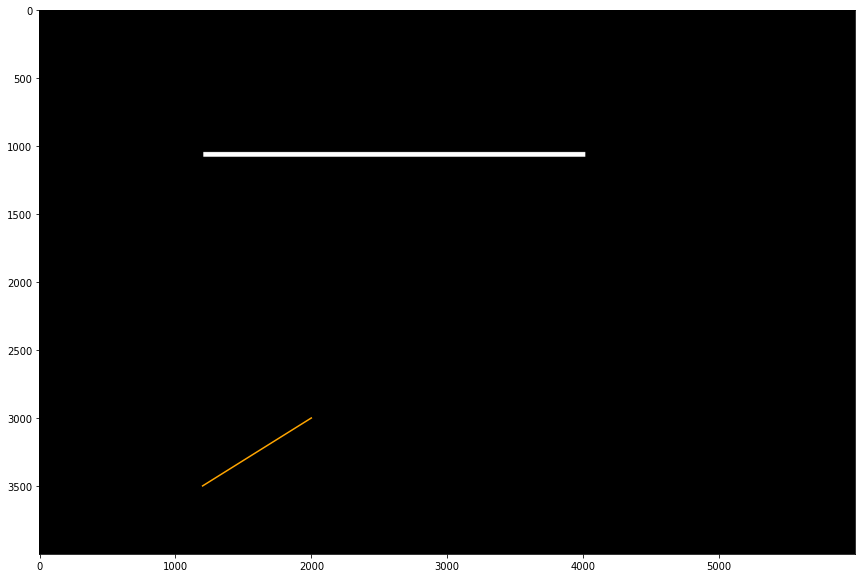

In [6]:
imgpath = "../data/50px_horiz.jpg"
p1=(2000, 3000)
p2=(1200, 3500)
print(imgpath, p1, p2)
img = io.imread(imgpath, as_gray=True)
print(img.shape)
# extent = (0, img.shape[1], 0, img.shape[0])
# fig, ax = plt.subplots()
# ax.imshow(img, origin="upper", extent=extent)
x, y = zip(p1, p2)
# ax.plot(x, y , "bo")
# fig.show()

fig, ax = plt.subplots(sharex="all", sharey="all")
ax.imshow(img, cmap=plt.cm.gray)
# ax.set_xlim(0, 6000)
# ax.set_ylim(0, 4000)
ax.plot(x, y, color='orange')
# ax.set_title('Summed')
plt.show()